# **Converting DICOM images to JPG Format**

### **Installing Dependencies**

In [1]:
!pip install pydicom

### **Importing Libraries**

In [2]:
import pydicom 
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image 
import numpy as np
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

### **Getting the Dataset Path**

In [3]:
path = "../input/inbreast-dataset/INbreast Release 1.0/AllDICOMs/"
single_img_path = "../input/inbreast-dataset/INbreast Release 1.0/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm"
target_path = "./IMAGES/"

In [4]:
medical_image = pydicom.read_file(single_img_path)

In [5]:
img = medical_image.pixel_array
print(img.shape)

(4084, 3328)


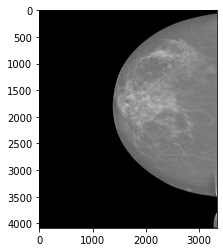

In [6]:
plt.imshow(img, cmap='gray')
plt.show()

In [7]:
image_dir= os.listdir(path)

In [8]:
len(image_dir)

412

### **Saving the converted images to jpg format**

In [9]:
errs = []

for img in image_dir:
    img_path = f'../input/inbreast-dataset/INbreast Release 1.0/AllDICOMs/{img}'
    img_id = img.split("_")[0]
    try:
        im = pydicom.dcmread(img_path)
    except:
        errs.append(img)
        continue
    im = im.pixel_array.astype(float)

    rescaled_image = (np.maximum(im,0)/im.max())*255 
    final_image = np.uint8(rescaled_image)

    final_image = Image.fromarray(final_image)
    # plt.imshow(final_image)
    if os.path.exists("./IMAGES/"):
        pass
    else:
        os.mkdir("./IMAGES")
        
    final_image.save(f"./IMAGES/{img_id}.jpg")

In [10]:
errs

['read_mixed_csv.m', 'inbreastBuilder.m']

### **Preprocessing the Dataset to process further** 

In [11]:
import re
import pandas as pd
import shutil
import sys

In [12]:
df = pd.read_csv("../input/inbreast-dataset/INbreast Release 1.0/INbreast.csv",sep=";")
df.head()

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads
0,removed,removed,R,CC,201001,22678622,4,1
1,removed,removed,L,CC,201001,22678646,4,3
2,removed,removed,R,MLO,201001,22678670,4,1
3,removed,removed,L,MLO,201001,22678694,4,3
4,removed,removed,R,CC,201001,22614074,2,5


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Patient ID        410 non-null    object
 1   Patient age       410 non-null    object
 2   Laterality        410 non-null    object
 3   View              410 non-null    object
 4   Acquisition date  410 non-null    int64 
 5   File Name         410 non-null    int64 
 6   ACR               410 non-null    object
 7   Bi-Rads           410 non-null    object
dtypes: int64(2), object(6)
memory usage: 25.8+ KB


### **Removing Characters from Bi-Rads**

In [14]:
df["Bi-Rads"].value_counts()

2     220
1      67
5      49
3      23
4c     22
4a     13
6       8
4b      8
Name: Bi-Rads, dtype: int64

In [15]:
df["Bi-Rads"].unique()

array(['1', '3', '5', '2', '4a', '4c', '6', '4b'], dtype=object)

In [16]:
df["Bi-Rads"] = df["Bi-Rads"].str.replace(r'[^0-9]+', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [17]:
df["Bi-Rads"].unique()

array(['1', '3', '5', '2', '4', '6'], dtype=object)

In [18]:
df["Bi-Rads"] = df["Bi-Rads"].astype(int)

In [19]:
result = []
for bi in df["Bi-Rads"]:
  if bi == 1:
    result.append("Normal")
  elif bi > 1 and bi < 3:
    result.append("Benign")
  else:
    result.append("Malignant")

df["Severity"] = result   

In [20]:
df.head()

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Severity
0,removed,removed,R,CC,201001,22678622,4,1,Normal
1,removed,removed,L,CC,201001,22678646,4,3,Malignant
2,removed,removed,R,MLO,201001,22678670,4,1,Normal
3,removed,removed,L,MLO,201001,22678694,4,3,Malignant
4,removed,removed,R,CC,201001,22614074,2,5,Malignant


In [21]:
df1 = df[["File Name", "Severity"]]
df1.head(3)

,File Name,Severity
0,22678622,Normal
1,22678646,Malignant
2,22678670,Normal


In [22]:
df1["File Name"] = df1["File Name"].astype("str")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### **Creating Directory for each class name and appending images**

In [23]:
os.mkdir('IMAGE_CLASS')

In [24]:
labels = df1
dir = r"./IMAGES/"
target_dir = r"./IMAGE_CLASS/"

for filename, class_name in labels.values:

  if not os.path.exists(target_dir + str(class_name)):
    os.mkdir(target_dir + str(class_name))
  
  src_path = dir + "/" + filename + ".jpg"
  dst_path = target_dir + str(class_name) + "/" + filename + ".jpg"

  try:
    shutil.copy(src_path, dst_path)
  except IOError as e:
    print(f"Unable to copy file {src_path} to {dst_path}")
  except:
    print(f"When try to copy file {src_path} to {dst_pth}, unexpected error:{sys.exc_info()}")

In [25]:
b = os.listdir("./IMAGE_CLASS/Benign")
m = os.listdir("./IMAGE_CLASS/Malignant")
n = os.listdir("./IMAGE_CLASS/Normal")

print(f"Number of images in Benign: {len(b)}")
print(f"Number of images in Malignant: {len(m)}")
print(f"Number of images in Normal: {len(n)}")

Number of images in Benign: 220
Number of images in Malignant: 123
Number of images in Normal: 67


# **Building DenseNet121 model to detect the class of image**

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [27]:
img_size = 256
batch_size = 2

In [28]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("./IMAGE_CLASS/",
                                                             shuffle= True,
                                                             seed = 12,
                                                             image_size=(img_size,img_size),
                                                             batch_size= batch_size)

Found 410 files belonging to 3 classes.


2022-07-15 06:13:37.538135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 06:13:37.709376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 06:13:37.710259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 06:13:37.713314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
class_name = dataset.class_names
class_name

['Benign', 'Malignant', 'Normal']

2022-07-15 06:13:47.310016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-15 06:13:47.347878: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 40774656 exceeds 10% of free system memory.
2022-07-15 06:13:47.348162: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25559040 exceeds 10% of free system memory.
2022-07-15 06:13:47.399764: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25559040 exceeds 10% of free system memory.
2022-07-15 06:13:47.411072: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25559040 exceeds 10% of free system memory.
2022-07-15 06:13:47.441111: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 40774656 exceeds 10% of free system memory.


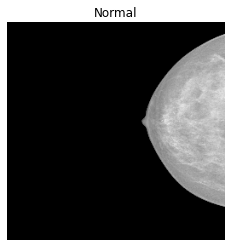

In [30]:
for img_batch, label_batch in dataset.take(1):
    plt.imshow(img_batch[1].numpy().astype("uint8"))
    plt.title(class_name[label_batch[1]])
    plt.axis("Off")

In [31]:
print("Number of batches in a Dataset:", len(dataset))

# Taking 80% of data for training purpose
train_ds = dataset.take(round(len(dataset)* 0.8))

# Skipping 80% of training data and Taking remaining 20% of data for Validation and Test
val_n_test = dataset.skip(round(len(dataset)*0.8))

# Taking 10% of data from val_n_test for validation and another 10% for test data
val_ds = val_n_test.take(round(len(val_n_test)*0.5))
test_ds = val_n_test.skip(round(len(val_n_test)*0.5))

print("Train Dataset:",len(train_ds))
print()
print("Number of batches selected for test and validation:", len(val_n_test))
print("Validation Dataset:",len(val_ds))
print("Test Dataset:", len(test_ds))

Number of batches in a Dataset: 205
Train Dataset: 164

Number of batches selected for test and validation: 41
Validation Dataset: 20
Test Dataset: 21


### **Model Architech**

In [80]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_ds,validation_data=val_ds,epochs=50)

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/50
164/164 [==============================] - 26s 117ms/step - loss: 1.4525 - accuracy: 0.4360 - val_loss: 1.2433 - val_accuracy: 0.5250
Epoch 2/50
164/164 [==============================] - 20s 120ms/step - loss: 1.0561 - accuracy: 0.4817 - val_loss: 0.9319 - val_accuracy: 0.6750
Epoch 3/50
164/164 [==============================] - 20s 118ms/step - loss: 1.0564 - accuracy: 0.4817 - val_loss: 0.9351 - val_accuracy: 0.6250
Epoch 4/50
164/164 [==============================] - 19s 112ms/step - loss: 0.9855 - accuracy: 0.5244 - val_loss: 0.8851 - val_accuracy: 0.5750
Epoch 5/50
164/164 [==============================] - 19s 112ms/step - loss: 0.9924 - accuracy: 0.5152 - val_loss: 0.8928 - val_accuracy: 0.5750
Epoch 6/50
164/164 [==============================] - 19s 114ms/step - loss: 0.9661 - accuracy: 0.5061 - val_loss: 0.9169 - val_accuracy: 0.5750
Epoch 7/50
164/164 [==============================] - 20s 122ms/s

In [81]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 9s 64ms/step - loss: 1.2792 - accuracy: 0.5952


In [82]:
scores

[1.2791961431503296, 0.5952380895614624]

In [83]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 164}

In [84]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [85]:
loss = history.history["loss"]
acc = history.history["accuracy"]

val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

In [ ]:
plt.plot(range(50), acc,'r' ,label="Accuracy")
plt.plot(range(50), val_acc, 'b',label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.grid(True)
plt.savefig('Malignancy_DenseNet121_Acc.jpg', dpi=400)

plt.plot(range(50), loss,'r', label="Loss")
plt.plot(range(50), val_loss,'b',label="Validation_Loss")
plt.legend(loc="upper right")
plt.title("Loss and Validation Loss")
plt.grid(True)
plt.savefig('Malignancy_DenseNet121_Loss.jpg', dpi=400)

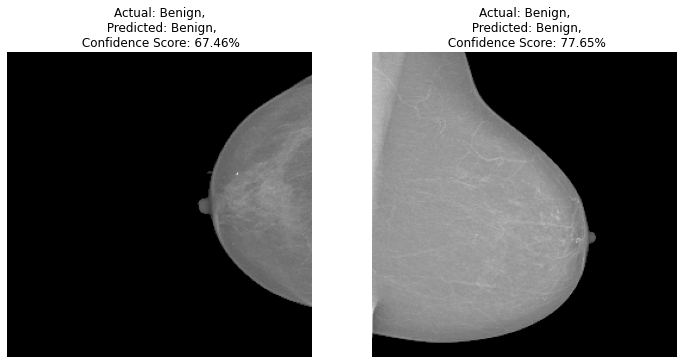

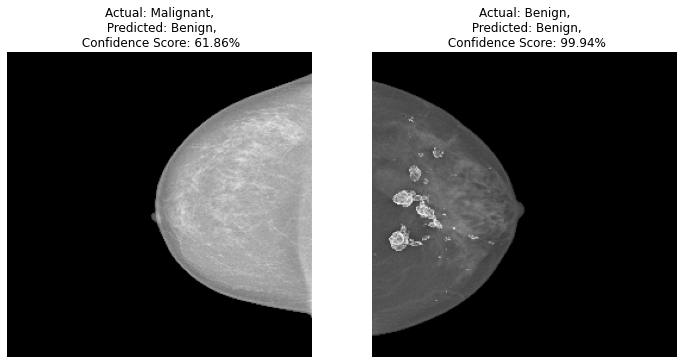

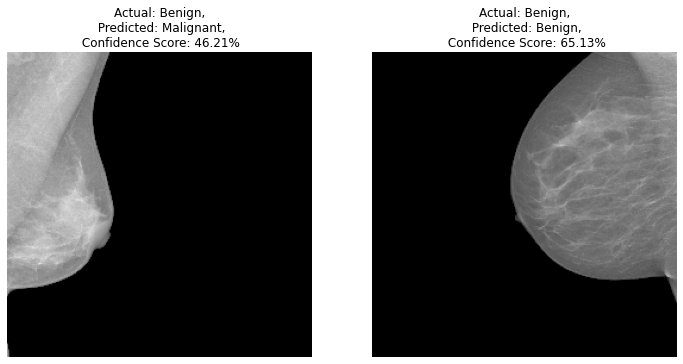

In [87]:
BATCH_SIZE = 2
for images, labels in val_ds.take(3):
    plt.figure(figsize=(12, 12))
    for i in range(BATCH_SIZE):
        ax = plt.subplot(1, 2, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        actual_cls = class_name[labels[i]]
        prediction = model.predict(images)
        predicted_cls = class_name[np.argmax(prediction[i])]
        confidence = round(100 * (np.max(prediction[i])), 2)
        plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
        plt.axis("off")
    plt.show()